# UNDERSTANDING CUSTOMER SHOPPING BEHAVIOR

<br>
Part 2 - This notebook contains order forecasting model which predicts the order compositions of customers in future. This analysis can be used to predict future product requirements and for inventory management.
<br>
(The project is broken into 2 noteboosk because the analysis is too heavy and jupyter gives memeory error is tried the entire project on 1 instance)

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost

In [2]:
aisles = pd.read_csv('dataset/aisles.csv')
departments = pd.read_csv('dataset/departments.csv')
products_prior = pd.read_csv('dataset/order_products__prior.csv')
products_train = pd.read_csv('dataset/order_products__train.csv')
orders = pd.read_csv('dataset/orders.csv')
products = pd.read_csv('dataset/products.csv')

## Feature Engineering
<br>
In the following cells, I have derived new set of charateristics from the existing dataset to make a more meaning model for the prediction.
<br>
(The cells takes forever to run hence I have saved the new dataset into a csv file for refernce.)

In [3]:
# function to groupby dataset based on some parameters
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)

    the_stats = grouped.agg(agg_dict)
    the_stats.columns = the_stats.columns.droplevel(0)
    the_stats.reset_index(inplace=True)
    if only_new_feature:
        df_new = the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    grouped_name = ''.join(group_columns_list)
    target_name = ''.join(target_columns_list)
    combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

    df_new = df.copy()
    grouped = df_new.groupby(group_columns_list)

    the_stats = grouped[target_name].agg(methods_list).reset_index()
    the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
    if keep_only_stats:
        return the_stats
    else:
        df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
    return df_new

#features based on the product data
priors_orders_detail = orders.merge(right=products_prior, how='inner', on='order_id')
priors_orders_detail.loc[:,'_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1
agg_dict = {'user_id':{'_prod_tot_cnts':'count'}, 
            'reordered':{'_prod_reorder_tot_cnts':'sum'}, 
            '_user_buy_product_times': {'_prod_buy_first_time_total_cnt':lambda x: sum(x==1),
                                        '_prod_buy_second_time_total_cnt':lambda x: sum(x==2)}}
prd = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['product_id'], agg_dict)


prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt

#features based on the customer data
agg_dict_2 = {'order_number':{'_user_total_orders':'max'},
              'days_since_prior_order':{'_user_sum_days_since_prior_order':'sum', 
                                        '_user_mean_days_since_prior_order': 'mean'}}
users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

agg_dict_3 = {'reordered':
              {'_user_reorder_ratio': 
               lambda x: sum(priors_orders_detail.ix[x.index,'reordered']==1)/
                         sum(priors_orders_detail.ix[x.index,'order_number'] > 1)},
              'product_id':{'_user_total_products':'count', 
                            '_user_distinct_products': lambda x: x.nunique()}}
us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

users['_user_average_basket'] = users._user_total_products / users._user_total_orders

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

#features based on the order data
agg_dict_4 = {'order_number':{'_up_order_count': 'count', 
                              '_up_first_order_number': 'min', 
                              '_up_last_order_number':'max'}, 
              'add_to_cart_order':{'_up_average_cart_position': 'mean'}}

data = ka_add_groupby_features_1_vs_n(df=priors_orders_detail, 
                                                      group_columns_list=['user_id', 'product_id'], 
                                                      agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')

data['_up_order_rate'] = data._up_order_count / data._user_total_orders
data['_up_order_since_last_order'] = data._user_total_orders - data._up_last_order_number
data['_up_order_rate_since_first_order'] = data._up_order_count / (data._user_total_orders - data._up_first_order_number + 1)

# add user_id to train set
train = products_train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

del priors_orders_detail, orders
gc.collect()



C:\Users\saksh\Anaconda3\lib\site-packages\pandas\core\groupby\generic.py:1455: FutureWarning: using a dict with renaming is deprecated and will be removed
in a future version.

For column-specific groupby renaming, use named aggregation

    >>> df.groupby(...).agg(name=('column', aggfunc))

  return super().aggregate(arg, *args, **kwargs)
C:\Users\saksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
C:\Users\saksh\Anaconda3\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
C:\Use

NameError: name 'gc' is not defined

In [7]:
data.head()

,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_buy_first_time_total_cnt,_prod_buy_second_time_total_cnt,...,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,27791,8000,4660,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,1389,557,308,...,59,18,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,3603,1923,1003,...,59,18,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,10,1,10,3.300000,6476,4797,1679,889,...,59,18,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,3,2,10,6.333333,3751,2465,1286,617,...,59,18,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


The above dataset consists of new derived features which will be sued to train the predictive model.<br>
The names of the features explain the derivation of these features.

In [8]:
#saving dataset for further use
data.to_csv("final_dataset.csv")

## Order Forecasting XGBoost predictive model
<br>
Further, an XGBoost tree model is built and its hyperparameters are tuned to get the best output.<br>
The output of the model gives future orders for all 75k customers, a list of products for every customers. These lists represent products that are most likely to be reodered by a customer.<br>
The model gives a probability of reordering to every product and picks products with probability more than 0.21 

In [4]:
#dataset size is 3.4M x 27, hence it takes forever to load
data = pd.read_csv("final_dataset.csv")

C:\Users\saksh\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\saksh\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[0]	train-logloss:0.62570
[10]	train-logloss:0.33500
[20]	train-logloss:0.26787
[30]	train-logloss:0.25047
[40]	train-logloss:0.24575
[50]	train-logloss:0.24414
[60]	train-logloss:0.24341
[70]	train-logloss:0.24285
[79]	train-logloss:0.24248


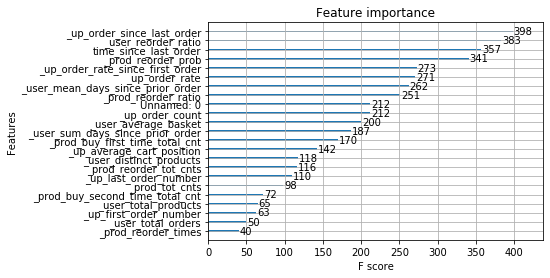

In [6]:
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test",:]

# subsample training
X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=0.9, random_state=42)
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

The above graph shows the feature importance of every derived feature. It makes sense that for predicting reordered products the sequence of adding products to cart and reorder ratio will be the most important features.

In [8]:
d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))
X_test.loc[:,'reordered'] = (bst.predict(d_test) > 0.21).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)
submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                               group_columns_list=['order_id'],
                                               target_columns_list= ['product_id'],
                                               methods_list=[lambda x: ' '.join(set(x))], keep_only_stats=True)
sample_submission = pd.read_csv('dataset/sample_submission.csv')
submit.columns = sample_submission.columns.tolist()
submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final.to_csv("final_output.csv", index=False)

The final output file contains the list of products which are most likely to be reordered by a customer.

In [9]:
submit_final

,order_id,products
0,17,21463 13107
1,34,16083 47792 47766 39475 39180 2596 21137 44663...
2,137,25890 23794 41787 38689 24852 5134 2326
3,182,47209 5479 11520 13629 47672 33000 39275 9337 ...
4,257,4605 27966 49235 39475 29837 37646 13870 28476...
...,...,...
74995,3420740,16291 35951 39146 19660 46252 49005 13176 8174
74996,3420877,7781 47209 27966 27845 13646 49111 42450 21137...
74997,3420888,10880 22935 35951 47766 7963 2361 28985 46906 ...
74998,3420989,21616 47766 43210 13517 35004 42450 46676 4722...


The above dataframe shows the output of the model. Here, each row represents the order_id for a particular customer and a list of products the customer is more likely to order.

In [11]:
output = submit_final['products'].str.cat(sep=' ')
output = output.split()
output_dict = pd.DataFrame(columns=["product_id","frequency"])
for w in products['product_id']:
    w= str(w)
    count = str(output.count(w))
    output_dict = output_dict.append({"product_id":w,"frequency":count},ignore_index=True)

#output_dict = output_dict.astype("object")
#output_df = output_dict.merge(products, on = ['product_id'])
#output_df.head()

In [24]:
output_dict['product_id'] = output_dict['product_id'].astype("int64")
output_dict['frequency'] = output_dict['frequency'].astype("int64")
output_df = pd.merge(output_dict,products,on = ['product_id','product_id'])
output_df = output_df[['product_name','frequency']]
output_df = output_df.sort_values(by=['frequency'],ascending=False)
output_df.head(10)

,product_name,frequency
24851,Banana,16935
13175,Bag of Organic Bananas,13611
21902,Organic Baby Spinach,8806
21136,Organic Strawberries,8278
47208,Organic Hass Avocado,6485
47765,Organic Avocado,6114
47625,Large Lemon,5299
27844,Organic Whole Milk,4249
16796,Strawberries,4178
27965,Organic Raspberries,4170


The above table gives the inventory requirement for the following 75k orders. 

# References

<br>
https://www.kaggle.com/c/instacart-market-basket-analysis/overview